In [1]:
import glob
import mne
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy import signal
import os

In [2]:
'''
read the data from the files
check if you nead to update path
'''
files_eeg_b= glob.glob(r"C:\Users\yehuda\pain_of_payment\Data_PoP\mindMonitor_*_b_*.csv", recursive= False)
files_eeg_q = glob.glob(r"C:\Users\yehuda\pain_of_payment\Data_PoP\mindMonitor_*_q_*.csv", recursive= False)
# sort the data files by subject number
regex = re.compile(r'\d+')
files_eeg_b.sort(key=lambda x: int(regex.findall(x)[-1]))
files_eeg_q.sort(key=lambda x: int(regex.findall(x)[-1]))

# read the questionarie payment information
questionarie_payment = pd.read_excel(r"C:\Users\yehuda\pain_of_payment\Pain of Payment Questionnaire.xlsx",\
                             usecols = ['Payment_method'], sheet_name='Sheet0')
questionarie_payment.drop(0, inplace=True)

# read the questionarie time of questions answer information
quastionarie_times = pd.read_excel(r"C:\Users\yehuda\pain_of_payment\Pain of Payment Questionnaire.xlsx",\
                             usecols = ['StartDate', 'T0_Page Submit', 'T1_Page Submit', 'Ttext1_Page Submit', 'T2_Page Submit', 
                                       'T3_Page Submit', 'Ttext2_Page Submit', 'T4_Page Submit'], sheet_name='Sheet0')
quastionarie_times.drop(0, inplace=True)
# caculate the end time of each question - meaning the exact time it was submitted. start time = previous question end time
quastionarie_times['StartDate'] = pd.to_datetime(quastionarie_times['StartDate']) # convert to datetime format
for i in range(1, len(quastionarie_times.columns)):
    quastionarie_times[quastionarie_times.columns[i]] = quastionarie_times[quastionarie_times.columns[i-1]] + pd.to_timedelta(quastionarie_times[quastionarie_times.columns[i]], unit='s')
# drop the date and microseconds
for i in range(len(quastionarie_times.columns)):
    quastionarie_times.iloc[:, i] = pd.to_timedelta(((quastionarie_times.iloc[:, i]).dt.floor('s')).dt.time.astype(str))

In [3]:
'''
initialize global variables
'''
freq_bands = dict(delta=(0.1,4), theta=(4,7), alpha=(8,15), beta=(16,31), gamma=(32,100))

# create info about the EEG expieremrnt
ch_names = ['EEG_channels']
ch_types = ['eeg']
sfreq = 256
info = mne.create_info(ch_names = ch_names, ch_types=ch_types, sfreq = sfreq)

In [4]:
def save_file(file_name, df_data, data_type, bool=False):
    # create folder named output if it doesn't exists
    folder_name = 'output_' + data_type
    file_name = file_name + ".csv"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # save data to the file inside folder
    file_path = os.path.join(folder_name, file_name)
    df_data.to_csv(file_path, index=bool, encoding = 'utf-8-sig')

In [5]:
'''
reading EEG measurements from time of buy +- 5 seconds 
using only the data from RAW_AF7 and RAW_AF8 electtrodes
'''
def read_b_data(file):
    
    # read data drom file
    df_data = pd.read_csv(file, low_memory=False, usecols = ['TimeStamp','RAW_AF7','RAW_AF8','ToB'])
    
    # adjust the time frame to be +- 5 seconds from time of buy
    ToB = pd.to_timedelta(df_data["ToB"].loc[0])
    before_5Sec = ToB - pd.to_timedelta("0:0:05")
    after_5Sec = ToB + pd.to_timedelta("0:0:05")
    df_data["TimeStamp"] = pd.to_timedelta(df_data["TimeStamp"])
    df_data_total_10 = df_data[(df_data["TimeStamp"] <= after_5Sec) & (df_data["TimeStamp"] >= before_5Sec)].copy()
    df_data_before_5 = df_data[(df_data["TimeStamp"] <= ToB) & (df_data["TimeStamp"] >= before_5Sec)].copy()
    df_data_after_5 = df_data[(df_data["TimeStamp"] <= after_5Sec) & (df_data["TimeStamp"] >= ToB)].copy()
    
    # for filtering a subject - may to check
    num_of_zeroes = (((df_data_total_10['RAW_AF7'] + df_data_total_10['RAW_AF8']) / 2) == 0).sum()
    
    # use only the RAW_AF7 and RAW_AF8 series
    df_data_total_10.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    df_data_before_5.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    df_data_after_5.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    
    #optional - to save to csv
#     save_file("df_data_total_10", df_data_total_10, 'b')
#     save_file("df_data_before_5", df_data_before_5, 'b')
#     save_file("df_data_after_5", df_data_after_5, 'b')
    
    return df_data_total_10, df_data_before_5, df_data_after_5

In [6]:
'''
reading EEG measurements of questions: pop1 - pop4
using only the data from RAW_AF7 and RAW_AF8 electtrodes
'''
def read_q_data(file, num_subject):
    
    # read data drom file
    df_data = pd.read_csv(file, low_memory=False, usecols = ['TimeStamp','RAW_AF7','RAW_AF8'])
    
    # adjust the time frame to questions pop1 - pop4
    subject_data = quastionarie_times.loc[num_subject]
    df_data["TimeStamp"] = pd.to_timedelta(df_data["TimeStamp"])
    df_data_pop1 = df_data[(df_data["TimeStamp"] <= subject_data["T1_Page Submit"]) & (df_data["TimeStamp"] >= subject_data["T0_Page Submit"])].copy()
    df_data_pop2 = df_data[(df_data["TimeStamp"] <= subject_data["T2_Page Submit"]) & (df_data["TimeStamp"] >= subject_data["Ttext1_Page Submit"])].copy()
    df_data_pop3 = df_data[(df_data["TimeStamp"] <= subject_data["T3_Page Submit"]) & (df_data["TimeStamp"] >= subject_data["T2_Page Submit"])].copy()
    df_data_pop4 = df_data[(df_data["TimeStamp"] <= subject_data["T4_Page Submit"]) & (df_data["TimeStamp"] >= subject_data["Ttext2_Page Submit"])].copy()
    
    # for filtering a subject - may to check
    
    # use only the RAW_AF7 and RAW_AF8 series
    df_data_pop1.drop(["TimeStamp"], inplace = True, axis=1)
    df_data_pop2.drop(["TimeStamp"], inplace = True, axis=1)
    df_data_pop3.drop(["TimeStamp"], inplace = True, axis=1)
    df_data_pop4.drop(["TimeStamp"], inplace = True, axis=1)
    
    #optional - to save to csv
#     save_file("df_data_pop1", df_data_pop1, 'q')
#     save_file("df_data_pop2", df_data_pop1, 'q')
#     save_file("df_data_pop3", df_data_pop1, 'q')
#     save_file("df_data_pop4", df_data_pop1, 'q')
    
    return df_data_pop1, df_data_pop2, df_data_pop3, df_data_pop4

In [7]:
'''
adjust the data from RAW_AF7 and RAW_AF8 electtrodes:
1) do detrend
2) do interpolation: for nan values and for data that is more than the 2xstd (standard deviation) 
3) take the mean between RAW_AF7 and RAW_AF8
'''
def adjust_data(df_data, time_frame_str, data_type):
    
    # Drop from df_data rows with all NaN values
    df_data.dropna(how='all', inplace = True)
    
    # replace zero values with NaN
    df_data.replace(to_replace=0, value=np.nan, inplace=True)
    
    # detrend the EEG signal for non-NaN values: both for RAW_AF7 and RAW_AF8
    for col in df_data.columns:
        # Boolean mask for non-NaN values
        mask = ~np.isnan(df_data[col])
        # Apply detrend only on non-NaN values
        signal.detrend(df_data.loc[mask, col], overwrite_data = True)
    
    # Interpolate missing values in RAW_AF7 and RAW_AF8 using the default linear method.
    # limit_direction='both' to to allow interpolation to the first and last values.
    # may - to check if limit is needed. if it is 1 it causes problems because of nan values
    df_data.interpolate(limit_direction='both', inplace=True)
    
    # interpolate values that exceed 2 std for RAW_AF7 and RAW_AF8 using the default linear method.
    for col in df_data.columns:
        mean = df_data[col].mean()
        std = df_data[col].std()
        outliers = (df_data[col] > mean + 2*std) | (df_data[col] < mean - 2*std)
        df_data.loc[outliers, col] = np.nan
        # may - to check if limit is needed- if it is 1 it causes problems because of nan values
        df_data[col].interpolate(limit_direction='both', inplace=True)
    
    # take the mean between RAW_AF7 and RAW_AF8
    df_data["EEG_channels"] = (df_data['RAW_AF7'] + df_data['RAW_AF8']) / 2
    
    # use only the EEG_channels serie
    df_data.drop(["RAW_AF7", "RAW_AF8"], inplace = True, axis=1)
    
    # optional - to save to csv
#     save_file("filter_df" +  time_frame_str, df_data, data_type)

    return df_data

In [8]:
'''
Analyzing the EEG data:
calculate Power Spectral Density
'''
def PSD(df_data, time_frame_str, data_type):
    df_data = df_data.transpose()
    raw = mne.io.RawArray(df_data, info)
    raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
    #raw.notch_filter(freqs=50, picks = 'eeg') - to check if needed
    
    # calculate Power Spectral Density 
    psd = raw.compute_psd(method = 'welch', picks = ['EEG_channels'])
    
    # optional - to plot
#     psd.plot()
    
    psd_df = psd.to_data_frame()
    
    # filter to frequancies between 0.1-100Hz
    psd_df = psd_df[(psd_df["freq"]<=100) & (psd_df["freq"]>=0.1)]
    
    # optional - to save to csv
#     save_file("psd_df" +  time_frame_str, psd_df, data_type)
    
    return psd_df

In [9]:
'''
calculate the mean of each wave band: delta, theta, alpha,beta, gama 
'''
def wave_bands(psd_df, num_subject):
    
    columns = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    subject_data={}
    i=0
    
    for wave, wave_range in freq_bands.items():
        wave_band = (psd_df[(psd_df['freq'] >= wave_range[0]) & (psd_df['freq'] <= wave_range[1])]['EEG_channels']).mean()
        subject_data[columns[i]] = [wave_band]
        i += 1
        
    df_subject_data = pd.DataFrame(subject_data)
    
    df_subject_data['subject'] = num_subject
    
    return df_subject_data

In [20]:
# remove subjects that their average exceed 5 std from the average of all participants
def filter_subjects(df_data):
    columns_to_mean = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    df_data_filtered = df_data.copy()
    df_data_filtered['waves_mean'] = df_data_filtered[columns_to_mean].mean(axis=1)
    mean = df_data_filtered['waves_mean'].mean()
    std = df_data_filtered['waves_mean'].std()
    print("mean is ", mean)
    print("std is ", std)
    df_data_filtered = df_data_filtered[(df_data_filtered['waves_mean'] <= (mean + 5*std)) & (df_data_filtered['waves_mean'] >= (mean - 5*std))]
    #df_data_filtered.drop('waves_mean', axis=1, inplace=True)
    return df_data_filtered

In [17]:
'''
calculate the mean power of each wave-band as a function of payment method
and display the results
for each time frame
'''
def based_payment(df_data, time_frame_str, data_type):
    df_based_payment = df_data.groupby('Payment_method').mean().drop(labels='subject', axis=1)

    # optional - to save to csv
    save_file("df_psd_based_payment" + time_frame_str, df_based_payment, data_type, True)
    
    return df_based_payment

In [18]:
# create a bar plot of the average power in each frequency band for each payment method
def my_plot(df_data, time_frame_str):
    
    ax = df_data.transpose().plot(kind='bar', figsize=(10, 6), rot=0, fontsize=10, y=['Cash', 'Credit Card', 'Smartphone'])

    # set the axis labels and title
    ax.set_xlabel('frequacy band', fontsize=12)
    ax.set_ylabel('Power', fontsize=12)
    title = 'Average Power by frequacy band and payment method ' + time_frame_str
    ax.set_title(title, fontsize=14)

    # display the plot
    plt.rcParams['font.family'] = 'Arial'
    plt.show()

In [21]:
'''
MAIN function to proccess the EEG_b data
proccessing to each subject its EEG data from the ToB:
1. the mean of each band wave
2. the payment method (takes the answer from the questionarie)
'''
# initilaize variables
num_subject = 1
time_frames = ["_total_10", "_before_5", "_after_5"]
df_all_subjects_data_total_10 = pd.DataFrame()
df_all_subjects_data_before_5 = pd.DataFrame()
df_all_subjects_data_after_5 = pd.DataFrame()
df_all_subjects_data = [df_all_subjects_data_total_10, df_all_subjects_data_before_5, df_all_subjects_data_after_5]

for file in files_eeg_b:
        
    # read the relevant data from Muse results 
    df_data_total_10, df_data_before_5, df_data_after_5 = read_b_data(file)
    df_times_data = [df_data_total_10, df_data_before_5, df_data_after_5]
    
    for index, time in enumerate(time_frames):
        df_time_data = df_times_data[index]
        
        # adjust and filter the data
        df_filter = adjust_data(df_time_data, time, 'b')
    
        # calculate Power Spectral Density
        df_PSD = PSD(df_filter, time, 'b')
    
        # seperate to frequacies bands (waves) and calculate the mean for each wave
        df_bands =  wave_bands(df_PSD, num_subject)
    
        # add the payment method of the subject
        df_bands['Payment_method'] = questionarie_payment['Payment_method'].loc[num_subject]
    
        # add current subject data to all the data that was collected so far
        df_all_subjects_data[index] = pd.concat([df_all_subjects_data[index], df_bands])
    
    num_subject += 1


df_filterd_subjects_data = []

for index, time in enumerate(time_frames):
    # optional - to save to csv
    save_file("df_all_subjects_data" + time, df_all_subjects_data[index], 'b')

    # calculate the mean power of each wave-band as a function of payment method
    df_mean_based_payment = based_payment(df_all_subjects_data[index], time, 'b')

    # plot the average power in each frequency band for each payment method
    my_plot(df_mean_based_payment, time)

for index, time in enumerate(time_frames):
    # remove subjects that their average exceed 5 std from the average of all participants
    df_filterd_subjects_data.append(filter_subjects(df_all_subjects_data[index]))
    
    # optional - to save to csv
    save_file("df_filterd_subjects_data" + time, df_filterd_subjects_data[index], 'b')
    
    # calculate the mean power of each wave-band as a function of payment method
    df_mean_based_payment = based_payment(df_all_subjects_data[index], time, 'b')

    # plot the average power in each frequency band for each payment method
    my_plot(df_mean_based_payment, time)

Creating RawArray with float64 data, n_channels=1, n_times=2832
    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1560
    Range : 0 ... 1559 =      0.000 ...     6.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1540
    Range : 0 ... 1539 =      0.000 ...     6.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2772
    Range : 0 ... 2771 =      0.000 ...    10.824 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

    Range : 0 ... 1559 =      0.000 ...     6.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2829
    Range : 0 ... 2828 =      0.000 ...    11.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1534
    Range : 0 ... 1533 =      0.000 ...     5.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2845
    Range : 0 ... 2844 =      0.000 ...    11.109 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2844
    Range : 0 ... 2843 =      0.000 ...    11.105 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1572
    Range : 0 ... 1571 =      0.000 ...     6.137 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2816
    Range : 0 ... 2815 =      0.000 ...    10.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1508
    Range : 0 ... 1507 =      0.000 ...     5.887 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2818
    Range : 0 ... 2817 =      0.000 ...    11.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1532
    Range : 0 ... 1531 =      0.000 ...     5.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1560
    Range : 0 ... 1559 =      0.000 ...     6.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1542
    Range : 0 ... 1541 =      0.000 ...     6.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1563
    Range : 0 ... 1562 =      0.000 ...     6.102 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transitio

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2803
    Range : 0 ... 2802 =      0.000 ...    10.945 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1516
    Range : 0 ... 1515 =      0.000 ...     5.918 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1569
    Range : 0 ... 1568 =      0.000 ...     6.125 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2813
    Range : 0 ... 2812 =      0.000 ...    10.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1541
    Range : 0 ... 1540 =      0.000 ...     6.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2834
    Range : 0 ... 2833 =      0.000 ...    11.066 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1550
    Range : 0 ... 1549 =      0.000 ...     6.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2814
    Range : 0 ... 2813 =      0.000 ...    10.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1530
    Range : 0 ... 1529 =      0.000 ...     5.973 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2829 =      0.000 ...    11.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1556
    Range : 0 ... 1555 =      0.000 ...     6.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2821
    Range : 0 ... 2820 =      0.000 ...    11.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2787 =      0.000 ...    10.887 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1496


num 1, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3577
    Range : 0 ... 3576 =      0.000 ...    13.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 1, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2549
    Range : 0 ... 2548 =      0.000 ...     9.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=3840
    Range : 0 ... 3839 =      0.000 ...    14.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 2, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=4877
    Range : 0 ... 4876 =      0.000 ...    19.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 2, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2316
    Range : 0 ... 2315 =      0.000 ...     9.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 3, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3096
    Range : 0 ... 3095 =      0.000 ...    12.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 3, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2300
    Range : 0 ... 2299 =      0.000 ...     8.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 3, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 4, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3288
    Range : 0 ... 3287 =      0.000 ...    12.840 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 4, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3588
    Range : 0 ... 3587 =      0.000 ...    14.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 4, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=3828
    Range : 0 ... 3827 =      0.000 ...    14.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 5, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1757
    Range : 0 ... 1756 =      0.000 ...     6.859 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 5, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 6, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=4368
    Range : 0 ... 4367 =      0.000 ...    17.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 6, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3852
    Range : 0 ... 3851 =      0.000 ...    15.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2075
    Range : 0 ... 2074 =      0.000 ...     8.102 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 7, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2304
    Range : 0 ... 2303 =      0.000 ...     8.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 7, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2292
    Range : 0 ... 2291 =      0.000 ...     8.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 9, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2304
    Range : 0 ... 2303 =      0.000 ...     8.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 9, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1264
    Range : 0 ... 1263 =      0.000 ...     4.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Effective window size : 1.000 (s)
num 9, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=1802
    Range : 0 ... 1801 =      0.000 ...     7.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 10, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2282
    Range : 0 ... 2281 =      0.000 ...     8.910 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 10, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2028
    Range : 0 ... 2027 =      0.000 ...     7.918 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
num 10, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=2061
    Range : 0 ... 2060 =      0.000 ...     8.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 11, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2281
    Range : 0 ... 2280 =      0.000 ...     8.906 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 11, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3319
    Range : 0 ... 3318 =      0.000 ...    12.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2810 =      0.000 ...    10.977 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 12, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=4080
    Range : 0 ... 4079 =      0.000 ...    15.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 12, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3317
    Range : 0 ... 3316 =      0.000 ...    12.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2580
    Range : 0 ... 2579 =      0.000 ...    10.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 13, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2844
    Range : 0 ... 2843 =      0.000 ...    11.105 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 13, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3086
    Range : 0 ... 3085 =      0.000 ...    12.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 14, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2830
    Range : 0 ... 2829 =      0.000 ...    11.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 14, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2572
    Range : 0 ... 2571 =      0.000 ...    10.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2556
    Range : 0 ... 2555 =      0.000 ...     9.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 14, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=1771
    Range : 0 ... 1770 =      0.000 ...     6.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
-----------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 15, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2302
    Range : 0 ... 2301 =      0.000 ...     8.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 15, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1264
    Range : 0 ... 1263 =      0.000 ...     4.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2304
    Range : 0 ... 2303 =      0.000 ...     8.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 16, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1800
    Range : 0 ... 1799 =      0.000 ...     7.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 16, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 17, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2028
    Range : 0 ... 2027 =      0.000 ...     7.918 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 17, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1812
    Range : 0 ... 1811 =      0.000 ...     7.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 18, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 18, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1800
    Range : 0 ... 1799 =      0.000 ...     7.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 19, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3600
    Range : 0 ... 3599 =      0.000 ...    14.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 19, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2590
    Range : 0 ... 2589 =      0.000 ...    10.113 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 20, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2063
    Range : 0 ... 2062 =      0.000 ...     8.055 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 20, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1800
    Range : 0 ... 1799 =      0.000 ...     7.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 21, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2814
    Range : 0 ... 2813 =      0.000 ...    10.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 21, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=4102
    Range : 0 ... 4101 =      0.000 ...    16.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 22, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=8724
    Range : 0 ... 8723 =      0.000 ...    34.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 22, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1775 =      0.000 ...     6.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 23, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3331
    Range : 0 ... 3330 =      0.000 ...    13.008 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 23, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2304
    Range : 0 ... 2303 =      0.000 ...     8.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 23, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=2556
    Range : 0 ... 2555 =      0.000 ...     9.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edg

C:\Users\yehuda\AppData\Local\Temp\ipykernel_22452\912506245.py:8: RuntimeWarning: filter_length (845) is longer than the signal (774), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 24, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2556
    Range : 0 ... 2555 =      0.000 ...     9.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 24, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1788
    Range : 0 ... 1787 =      0.000 ...     6.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2295 =      0.000 ...     8.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 25, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2316
    Range : 0 ... 2315 =      0.000 ...     9.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 25, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2048
    Range : 0 ... 2047 =      0.000 ...     7.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2556
    Range : 0 ... 2555 =      0.000 ...     9.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 26, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=5137
    Range : 0 ... 5136 =      0.000 ...    20.062 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 26, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2322
    Range : 0 ... 2321 =      0.000 ...     9.066 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
num 26, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=4095
    Range : 0 ... 4094 =      0.000 ...    15.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 27, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3061
    Range : 0 ... 3060 =      0.000 ...    11.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 27, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 27, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=1266
    Range : 0 ... 1265 =      0.000 ...     4.941 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 28, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2553
    Range : 0 ... 2552 =      0.000 ...     9.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 28, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2293
    Range : 0 ... 2292 =      0.000 ...     8.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 28, question _pop4
Creating RawArray with float64 data, n_channels=1, n_times=1535
    Range : 0 ... 1534 =      0.000 ...     5.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 29, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2316
    Range : 0 ... 2315 =      0.000 ...     9.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 29, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3572
    Range : 0 ... 3571 =      0.000 ...    13.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 30, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2570
    Range : 0 ... 2569 =      0.000 ...    10.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 30, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2301
    Range : 0 ... 2300 =      0.000 ...     8.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1786
    Range : 0 ... 1785 =      0.000 ...     6.973 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 31, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1800
    Range : 0 ... 1799 =      0.000 ...     7.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 31, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1281
    Range : 0 ... 1280 =      0.000 ...     5.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2321
    Range : 0 ... 2320 =      0.000 ...     9.062 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 32, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 32, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1784
    Range : 0 ... 1783 =      0.000 ...     6.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\yehuda\AppData\Local\Temp\ipykernel_22452\912506245.py:8: RuntimeWarning: filter_length (845) is longer than the signal (768), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(

num 33, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=3348
    Range : 0 ... 3347 =      0.000 ...    13.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 33, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2046
    Range : 0 ... 2045 =      0.000 ...     7.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 34, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2053
    Range : 0 ... 2052 =      0.000 ...     8.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 34, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1821
    Range : 0 ... 1820 =      0.000 ...     7.109 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 2312 =      0.000 ...     9.031 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 35, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2822
    Range : 0 ... 2821 =      0.000 ...    11.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 35, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2031
    Range : 0 ... 2030 =      0.000 ...     7.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 36, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=4372
    Range : 0 ... 4371 =      0.000 ...    17.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 36, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=5124
    Range : 0 ... 5123 =      0.000 ...    20.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 37, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 37, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1277
    Range : 0 ... 1276 =      0.000 ...     4.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 38, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1344
    Range : 0 ... 1343 =      0.000 ...     5.246 secs
Ready.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 38, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=432
    Range : 0 ... 431 =      0.000 ...     1.684 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\yehuda\AppData\Local\Temp\ipykernel_22452\912506245.py:8: RuntimeWarning: filter_length (845) is longer than the signal (432), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 39, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2545
    Range : 0 ... 2544 =      0.000 ...     9.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 39, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2297
    Range : 0 ... 2296 =      0.000 ...     8.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1010 =      0.000 ...     3.945 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 40, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1272
    Range : 0 ... 1271 =      0.000 ...     4.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 40, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2072
    Range : 0 ... 2071 =      0.000 ...     8.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\yehuda\AppData\Local\Temp\ipykernel_22452\912506245.py:8: RuntimeWarning: filter_length (845) is longer than the signal (756), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
[Parallel(

num 41, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=4109
    Range : 0 ... 4108 =      0.000 ...    16.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 41, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2557
    Range : 0 ... 2556 =      0.000 ...     9.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 42, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2287
    Range : 0 ... 2286 =      0.000 ...     8.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 42, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 43, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2574
    Range : 0 ... 2573 =      0.000 ...    10.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 43, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3077
    Range : 0 ... 3076 =      0.000 ...    12.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 44, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1537
    Range : 0 ... 1536 =      0.000 ...     6.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 44, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1776
    Range : 0 ... 1775 =      0.000 ...     6.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1525 =      0.000 ...     5.957 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 45, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1788
    Range : 0 ... 1787 =      0.000 ...     6.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 45, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1800
    Range : 0 ... 1799 =      0.000 ...     7.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1295 =      0.000 ...     5.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 46, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1824
    Range : 0 ... 1823 =      0.000 ...     7.121 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 46, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 47, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=9444
    Range : 0 ... 9443 =      0.000 ...    36.887 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 47, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3082
    Range : 0 ... 3081 =      0.000 ...    12.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 48, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2564
    Range : 0 ... 2563 =      0.000 ...    10.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 48, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2052
    Range : 0 ... 2051 =      0.000 ...     8.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 49, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=4610
    Range : 0 ... 4609 =      0.000 ...    18.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 49, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2297
    Range : 0 ... 2296 =      0.000 ...     8.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 50, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2040
    Range : 0 ... 2039 =      0.000 ...     7.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 50, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=4092
    Range : 0 ... 4091 =      0.000 ...    15.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 51, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 51, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 52, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1786
    Range : 0 ... 1785 =      0.000 ...     6.973 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 52, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2051
    Range : 0 ... 2050 =      0.000 ...     8.008 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


num 53, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=2310
    Range : 0 ... 2309 =      0.000 ...     9.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 53, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=3084
    Range : 0 ... 3083 =      0.000 ...    12.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
num 54, question _pop1
Creating RawArray with float64 data, n_channels=1, n_times=1278
    Range : 0 ... 1277 =      0.000 ...     4.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num 54, question _pop2
Creating RawArray with float64 data, n_channels=1, n_times=2052
    Range : 0 ... 2051 =      0.000 ...     8.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


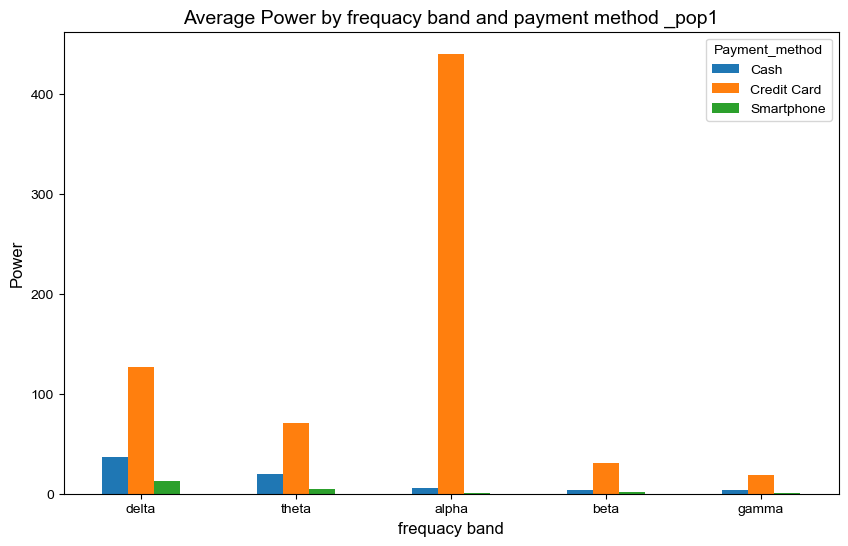

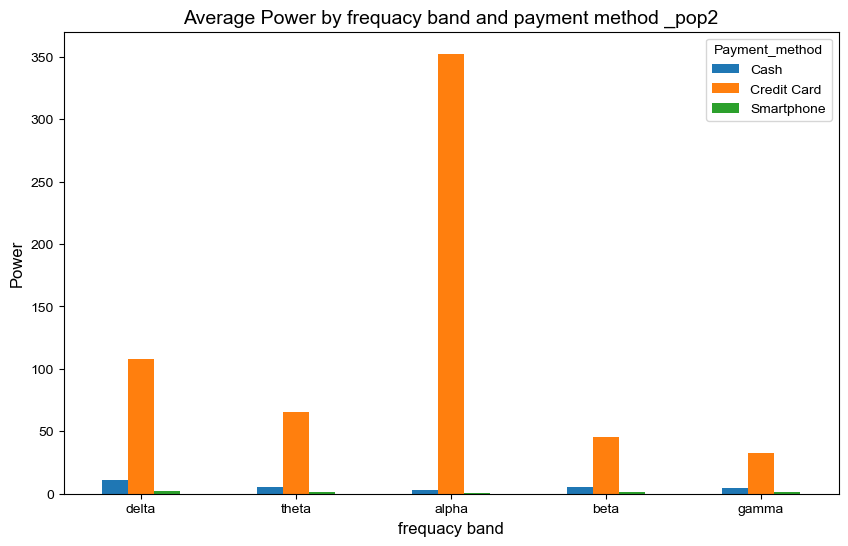

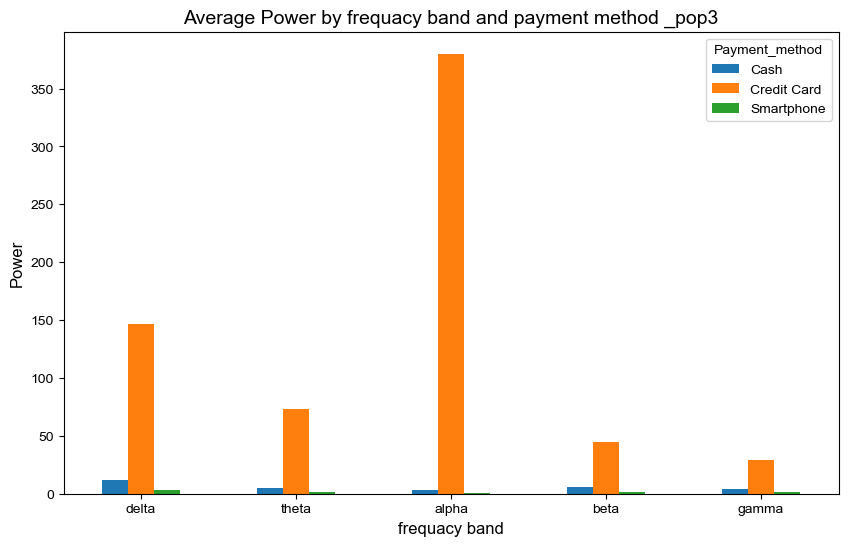

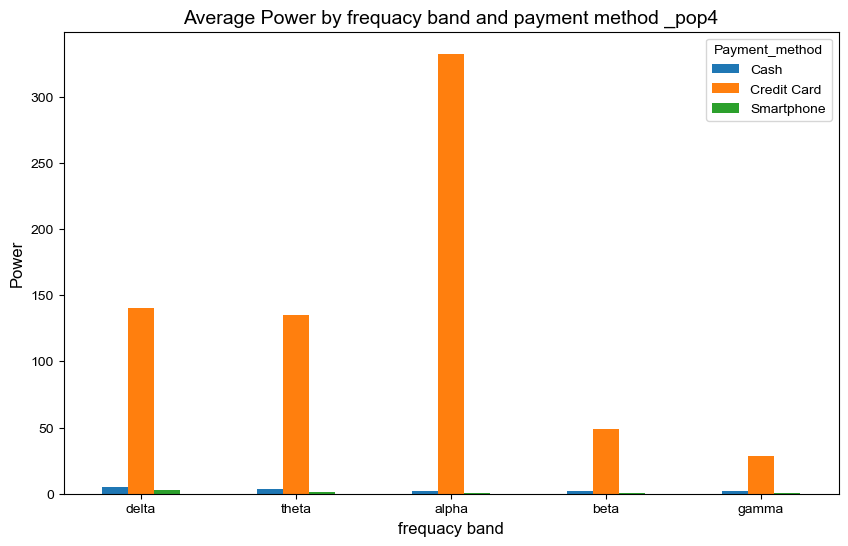

In [13]:
'''
MAIN function to proccess the EEG_q data
proccessing to each subject its EEG data based on the questions timer time:
1. the mean of each band wave
2. the payment method (takes the answer from the questionarie)
'''
# initilaize variables
num_subject = 1
questions = ["_pop1", "_pop2", "_pop3", "_pop4"]
df_all_subjects_data_pop1 = pd.DataFrame()
df_all_subjects_data_pop2 = pd.DataFrame()
df_all_subjects_data_pop3 = pd.DataFrame()
df_all_subjects_data_pop4 = pd.DataFrame()
df_all_subjects_data = [df_all_subjects_data_pop1, df_all_subjects_data_pop2, df_all_subjects_data_pop3, df_all_subjects_data_pop4]

for file in files_eeg_q:
    
    # may - to delete it is just to continue without subject 8
    if num_subject == 8:
        num_subject += 1
        continue
        
    # read the relevant data from Muse results 
    df_data_pop1, df_data_pop2, df_data_pop3, df_data_pop4 = read_q_data(file, num_subject)
    df_questions_data = [df_data_pop1, df_data_pop2, df_data_pop3, df_data_pop4]
    
    for index, question in enumerate(questions):
        df_question_data = df_questions_data[index]
        
        # adjust and filter the data
        print(f"num {num_subject}, question {question}")
        df_filter = adjust_data(df_question_data, question, 'q')
    
        # calculate Power Spectral Density
        df_PSD = PSD(df_filter, time, 'q')
    
        # seperate to frequacies bands (waves) and calculate the mean for each wave
        df_bands =  wave_bands(df_PSD, num_subject)
    
        # add the payment method of the subject
        df_bands['Payment_method'] = questionarie_payment['Payment_method'].loc[num_subject]
    
        # add current subject data to all the data that was collected so far
        df_all_subjects_data[index] = pd.concat([df_all_subjects_data[index], df_bands])
    
    num_subject += 1

for index, question in enumerate(questions):
    # optional - to save to csv
    save_file("df_all_subjects_data" + question, df_all_subjects_data[index], 'q')

    # calculate the mean power of each wave-band as a function of payment method
    df_mean_based_payment = based_payment(df_all_subjects_data[index], question, 'q')

    # plot the average power in each frequency band for each payment method
    my_plot(df_mean_based_payment, question)